In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>")) 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import datetime
import matplotlib.pyplot as plt
import glob
import os
from obspy import read, UTCDateTime, read_inventory
from obspy.signal import PPSD
import warnings
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use("ggplot")

from msnoise.api import *
from wxs_dvv import *

plt.rcParams['figure.figsize'] = (16,8)

/tmp/ipykernel_366557/1361000500.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# connect to the database
db = connect()
params = get_params(db)

In [3]:
for filter in get_filters(db):
    filter.used = False
db.commit()
update_filter(db, ref=5, low=0.5, mwcs_low=0.5, high=8, mwcs_high=8, mwcs_wlen=4, mwcs_step=1, used=1)


In [4]:
! msnoise info


General:
 - the MSNoise module is installed in: /home/raphael/WORK/MSNoise_wavelet/MSNoise
 - db.ini is present in the current directory
Database information stored in the db.ini file:
 - database type: SQLite
 - filename: db.sqlite

Configuration:
 - /home/raphael/Desktop/SKIENCE24/DATA/SDS exists
 - CROSS_CORRELATIONS exists

Configuration values:   | Normal colour indicates that the default value is used   | Green indicates "M"odified values
 M data_folder: /home/raphael/Desktop/SKIENCE24/DATA/SDS
   output_folder: CROSS_CORRELATIONS
   data_structure: SDS
   archive_format: ''
   network: *
   channels: *
   startdate: 1970-01-01
   enddate: 2100-01-01
   analysis_duration: 86400
   cc_sampling_rate: 20
   cc_normalisation: NO
   resampling_method: Decimate
   preprocess_lowpass: 8
   preprocess_highpass: 0.01
   preprocess_max_gap: 10
   preprocess_taper_length: 20
   remove_response: N
   response_format: dataless
 M response_path: /home/raphael/Desktop/SKIENCE24/DATA/Response
 

In [5]:
! msnoise config set mov_stack=(('1d','1d'),('2d','1d'),('12h','3h'))
! msnoise config set components_to_compute_single_station=EN,EZ,NZ
! msnoise config set components_to_compute=""
! msnoise reset DA
! msnoise new_jobs
! msnoise db execute "update jobs set flag='D' where jobtype='CC'"
! msnoise db execute "update jobs set flag='T' where jobtype='CC' and day between '2014-06-01' and '2014-07-01'"

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: ` msnoise config set mov_stack=(('1d','1d'),('2d','1d'),('12h','3h'))'
Successfully updated parameter components_to_compute_single_station = EN,EZ,NZ
Successfully updated parameter components_to_compute = 
2024-03-02 08:42:04.456781 msnoise [INFO]: *** Starting: New Jobs ***
2024-03-02 08:42:04.562804 msnoise [INFO]: Scanning New/Modified files
2024-03-02 08:42:04.728435 msnoise [INFO]: Determining available data for each "updated date"
2024-03-02 08:42:05.152747 msnoise [INFO]: Inserted 734 jobs
2024-03-02 08:42:05.152826 msnoise [INFO]: *** Finished: New Jobs ***
2024-03-02 08:42:06.087299 msnoise [INFO]: Executing 'update jobs set flag='D' where jobtype='CC''
2024-03-02 08:42:07.040028 msnoise [INFO]: Executing 'update jobs set flag='T' where jobtype='CC' and day between '2014-06-01' and '2014-07-01''


In [ ]:
! msnoise info -j

In [7]:
! msnoise -q -t 6 cc compute_cc

/home/raphael/anaconda3/envs/msnoise2/lib/python3.11/site-packages/obspy/io/mseed/core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)
/home/raphael/anaconda3/envs/msnoise2/lib/python3.11/site-packages/obspy/io/mseed/core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)
/home/raphael/anaconda3/envs/msnoise2/lib/python3.11/site-packages/obspy/io/mseed/core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)
/home/raphael/anaconda3/envs/msnoise2/lib/python3.11/site-packages/obspy/io/mseed/core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the 

In [10]:
# Obtain a list of dates between ``start_date`` and ``enddate``
start, end, datelist = build_movstack_datelist(db)

# Get the list of parameters from the DB:
params = get_params(db)


# Get the time axis for plotting the CCF:
taxis = get_t_axis(db)

filter_id = 5
comp = "EN"
# Get the results for two station, filter id=1, ZZ component, mov_stack=("1d","1d") and the results as a 2D array:
ccfs = get_results_all(db, "PF.CSS.00", "PF.CSS.00", filter_id, "EN", datelist, format="xarray")


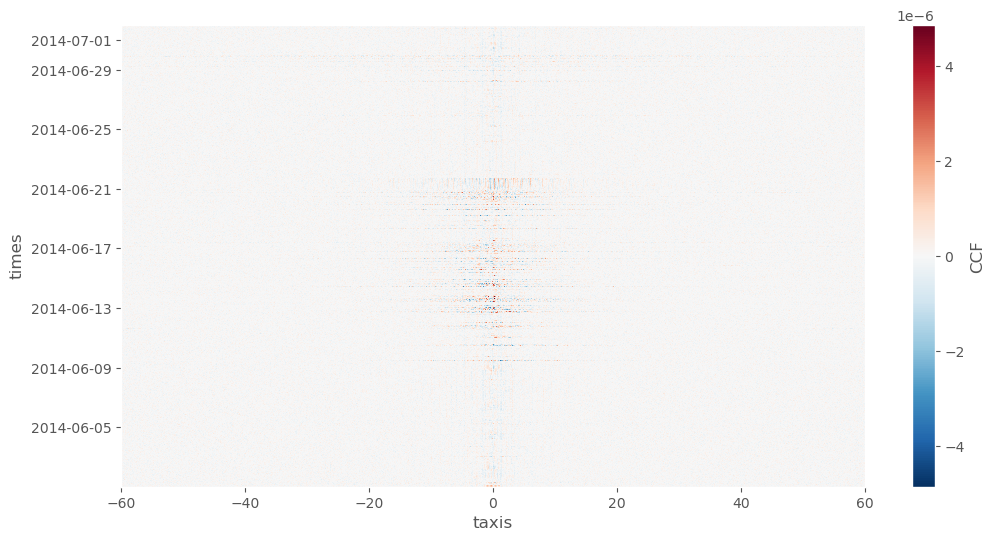

In [9]:
ccfs.CCF.plot(figsize=(12,6))

In [10]:
zoom = 20 # seconds in the coda

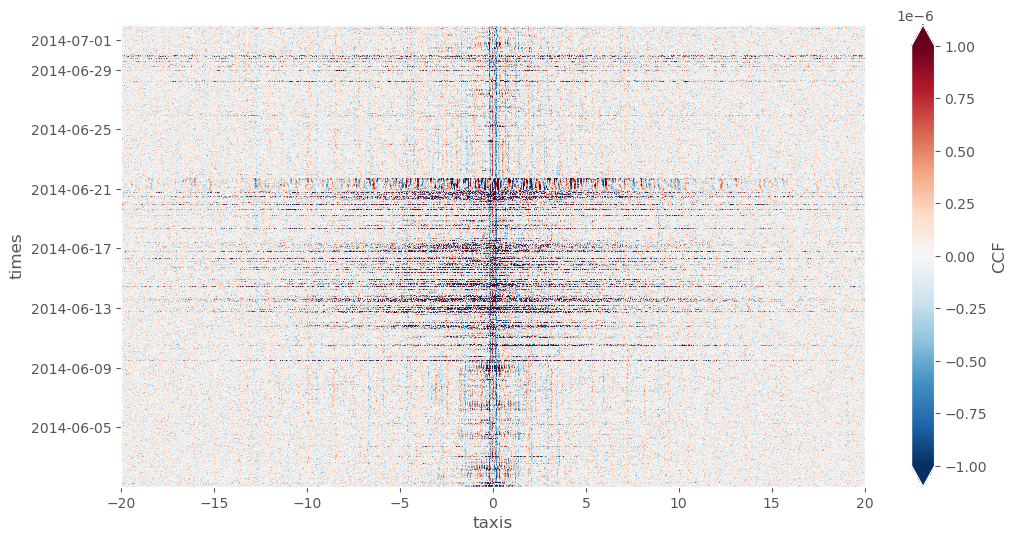

In [11]:
ccfs.CCF.loc[:,-zoom:zoom].plot(figsize=(12,6), vmin=-1e-6)

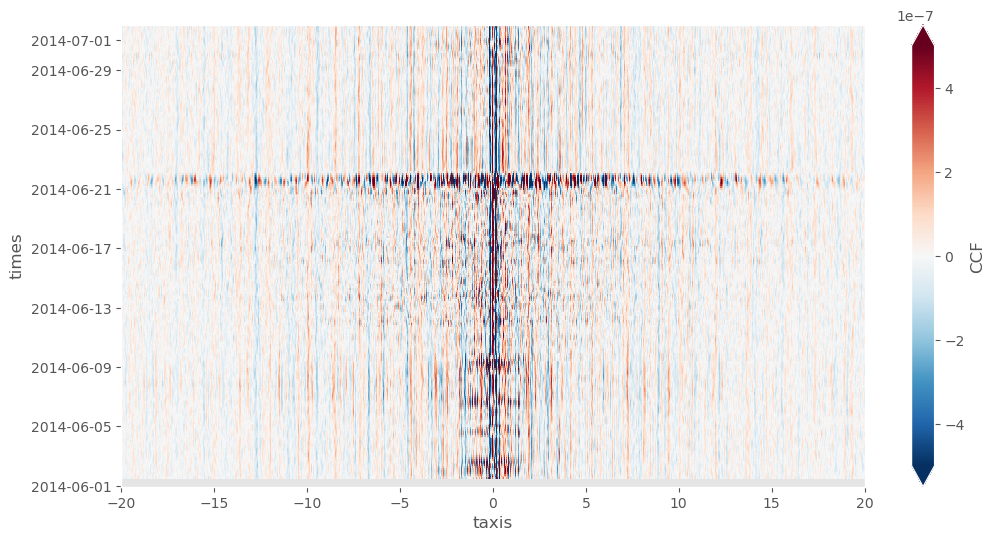

In [12]:
ccfs.CCF.loc[:,-zoom:zoom].rolling(times=24).mean().resample(times='3h').mean().plot(figsize=(12,6), vmin=-5e-7)

In [13]:
! msnoise -q -t 6 cc stack -r

Lets STACK !


In [14]:
! msnoise reset STACK
! msnoise -q -t 6 cc stack -m

Lets STACK !


In [15]:
# ! msnoise db execute "update jobs set flag='T' where jobtype='MWCS' and day between '2014-06-01' and '2014-07-01'"
! msnoise -q -t 5 cc dvv compute_mwcs

In [16]:
! msnoise -q -t 5 cc dvv compute_dtt

In [17]:
! msnoise -q cc dvv compute_dvv

('1d', '1d')


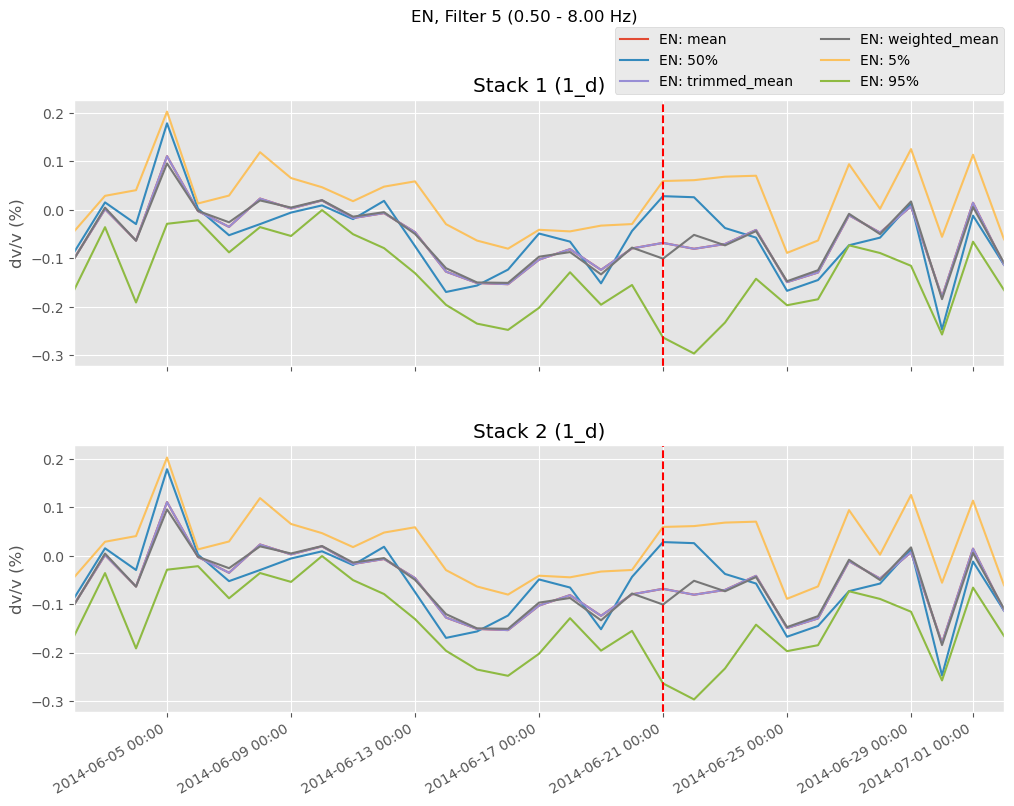

('1d', '1d')


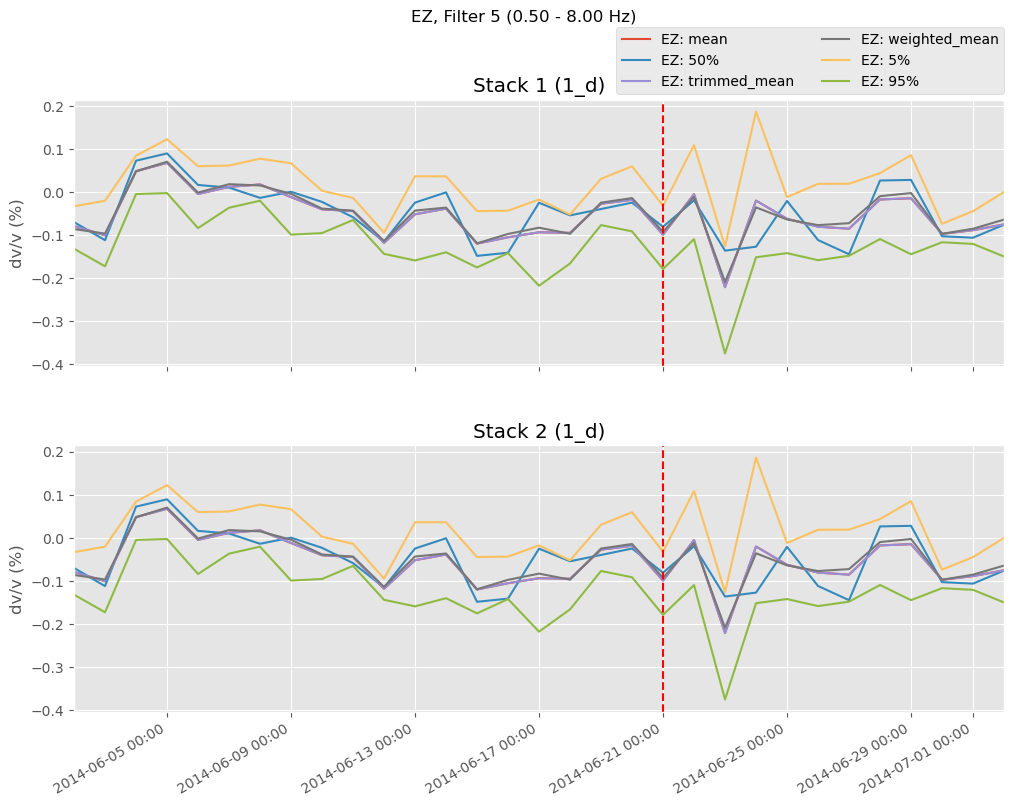

('1d', '1d')


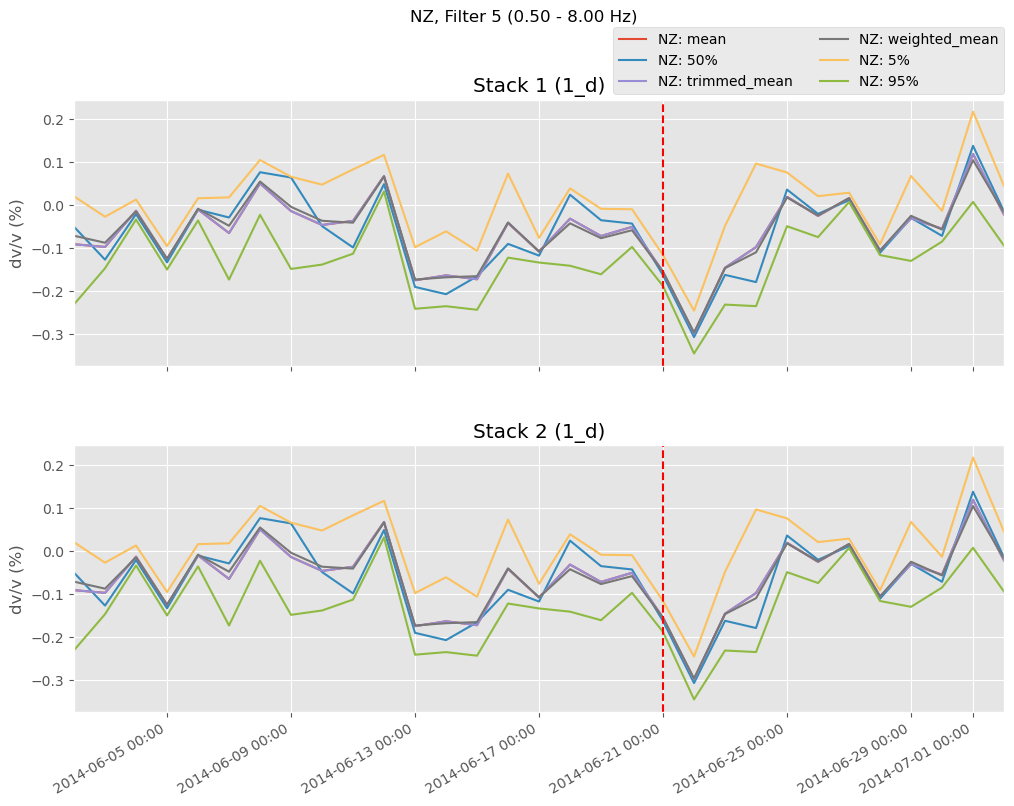

In [5]:
from msnoise.plots.dvv import main as plot_dvv
for comp in ["EN", "EZ", "NZ"]:
    plot_dvv(filterid=5, components=comp, show=False)
    for ax in plt.gcf().axes:
        plt.sca(ax)
        plt.axvline(datetime.datetime(2014,6,21,),c='r', ls='--')
    plt.show()

In [19]:
# plot_dvv(filterid=5, components="EZ,NZ,EN", show=False)
# for ax in plt.gcf().axes:
#     plt.sca(ax)
#     plt.axvline(datetime.datetime(2014,6,21,),c='r', ls='--')
# plt.show()

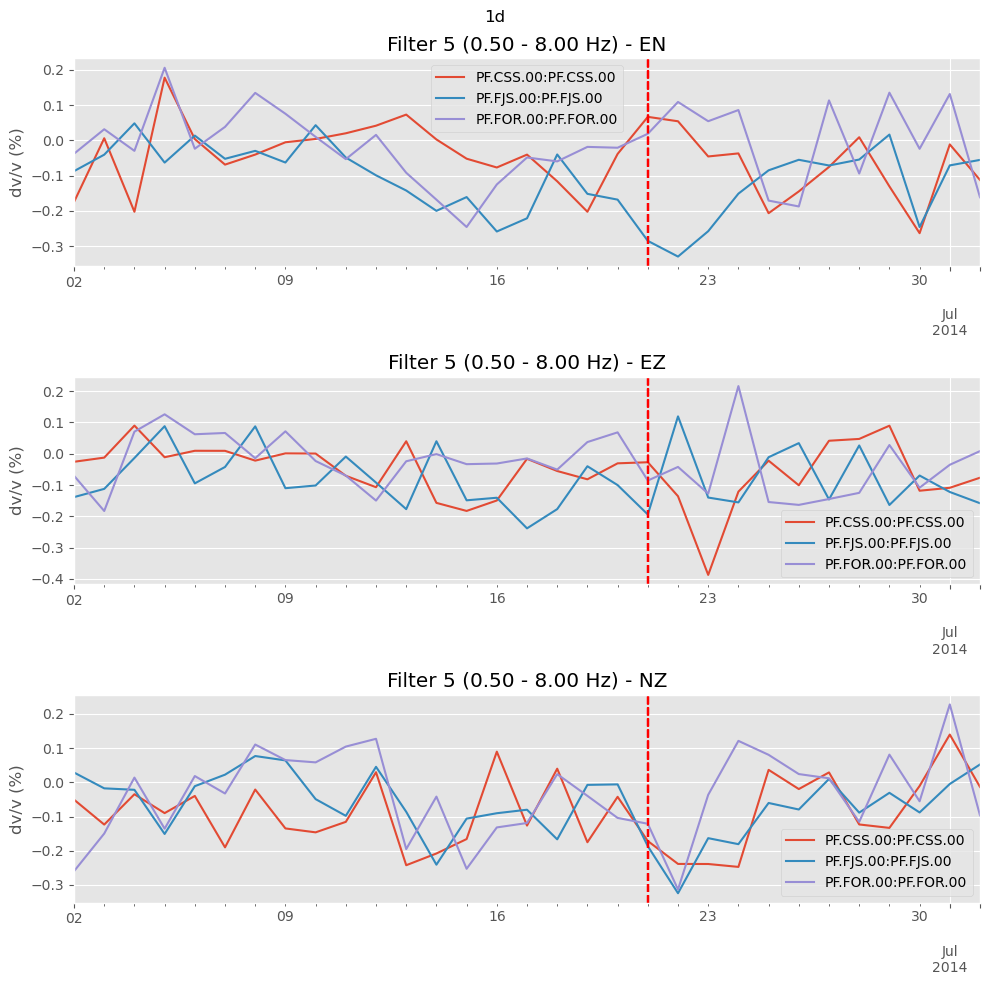

In [6]:
fig, axes = plt.subplots(3,1, figsize=(10,10))
filterid = 5
mov_stack = params.mov_stack[-1]
plt.suptitle(mov_stack)
filter = get_filters(db, ref=filterid)
for i, comp in enumerate(["EN", "EZ", "NZ"]):
    for sta1, sta2 in get_station_pairs(db):
        plt.sca(axes[i])
        for loc1 in sta1.locs():
            s1 = "%s.%s.%s" % (sta1.net, sta1.sta, loc1)
            for loc2 in sta2.locs():
                s2 = "%s.%s.%s" % (sta2.net, sta2.sta, loc2)
                if s1 != s2:
                    continue
                dvv = compute_dvv(db, filterid, mov_stack, components=comp, params=params, pairs=[(s1,s2),])
                dvv.m0 *= -100
                # dvv = dvv.rolling("24h", closed="right", center=False).mean()
                dvv.m0.plot(label="%s:%s"%(s1,s2), ax=axes[i])
                plt.title("Filter %i (%.2f - %.2f Hz) - %s" % (filterid, filter.low, filter.high, comp))
        plt.axvline(datetime.date(2014,6,21), c='r', ls='--')
        plt.legend()
        plt.xlabel("")
        plt.ylabel("dv/v (%)")
plt.tight_layout()

Wavelet Method

In [13]:


ref=ccfs.CCF.median(axis=0).data
current = ccfs.CCF[600].data
t = ccfs.CCF.mean(axis=0).taxis.data
ori_waveform = (ref/ref.max())
new_waveform = (current/current.max())

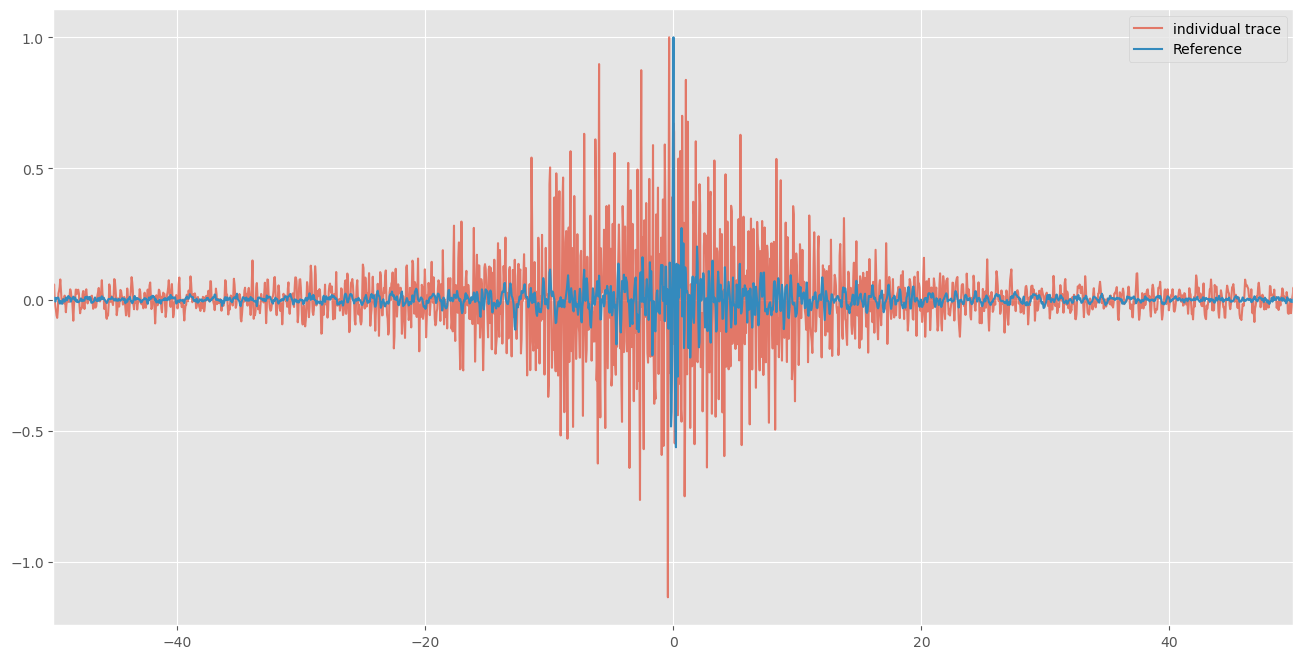

In [14]:
fig = plt.figure()
plt.plot(t,new_waveform, label="individual trace", alpha=0.7)
plt.plot(t,ori_waveform, label="Reference")

plt.xlim(-50,50)
plt.legend()
plt.show()

In [15]:
filters = get_filters(db, all=False)

In [16]:
# We'll start with a broad-ish frequency range, and play with it later
freqmin=filters[0].low
freqmax=filters[0].high
fs = params.cc_sampling_rate
lag_min = params.dtt_minlag
lag_max = params.dtt_minlag+params.dtt_width


pair="PF.CSS.00:PF.CSS.00"
date = ccfs.CCF[600].times.data

In [19]:
# Cross wavelet transform
WXamp, WXspec, WXangle, Wcoh, WXdt, freqs, coi = xwt(ori_waveform, new_waveform, fs, 3, 0.25, 10, freqmin, freqmax, 100)

In [20]:
# get the dv/v from the linear regression and the weighting function
dvv, err, wf =get_dvv(freqs, t, WXamp, Wcoh, WXdt, lag_min, lag_max, freqmin=freqmin, freqmax=freqmax)

In [21]:
#Plotting the results
do_plot(t, WXamp, WXspec, WXangle, Wcoh, WXdt, freqs, coi, wf, pair, date, comp)

Processing PF.FOR.00:PF.FOR.00 f5 m1d EN


looping through dates 2014-07-01T23:30:00.000000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1457/1457 [12:46<00:00,  1.90it/s]
Formating the DataFrame: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1457/1457 [00:00<00:00, 13355.32it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Processing PF.FOR.00:PF.FOR.00 f5 m1d EZ


looping through dates 2014-07-01T23:30:00.000000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1457/1457 [12:39<00:00,  1.92it/s]
Formating the DataFrame: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1457/1457 [00:00<00:00, 13997.57it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Processing PF.FOR.00:PF.FOR.00 f5 m1d NZ


looping through dates 2014-07-01T23:30:00.000000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1457/1457 [12:37<00:00,  1.92it/s]
Formating the DataFrame: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1457/1457 [00:00<00:00, 12966.07it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


All done!


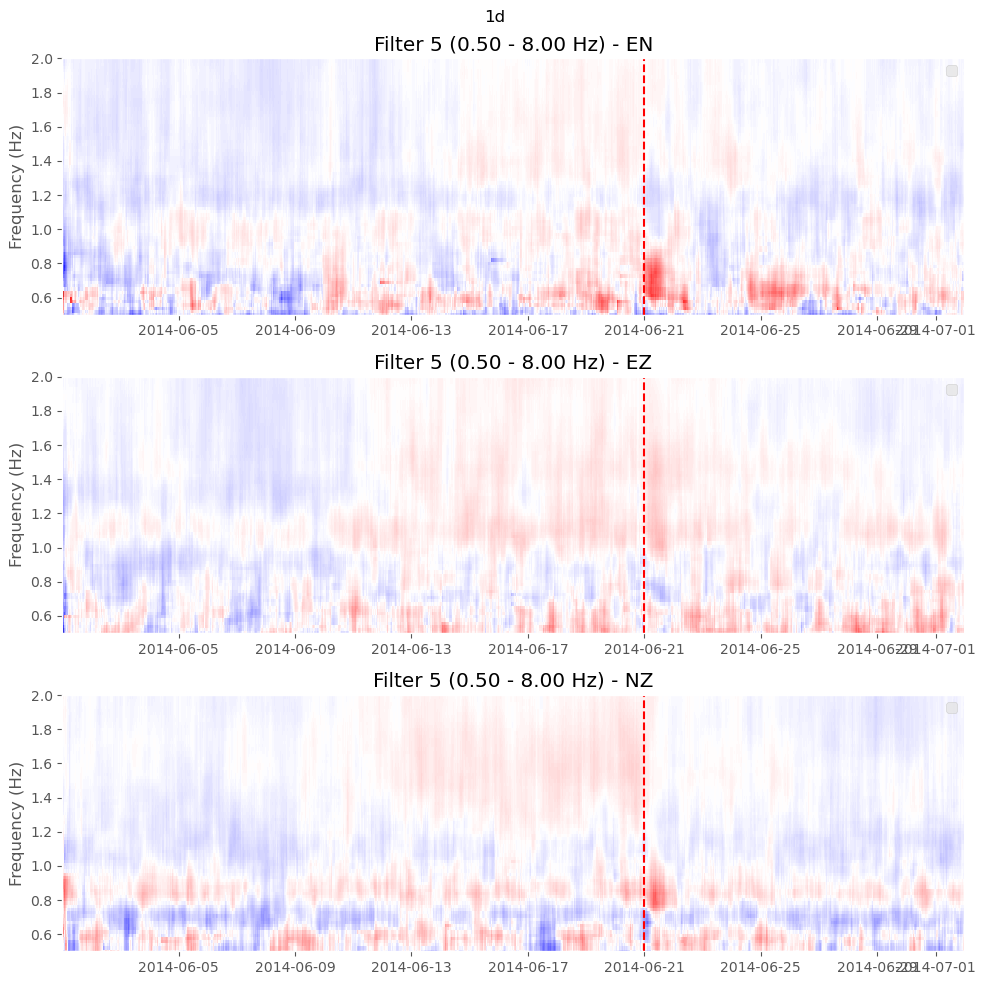

In [57]:
plot = False
saveit=True
import tqdm
comps=["EN", "EZ", "NZ"]
fig, axes = plt.subplots(len(comps),1, figsize=(10,10))
filterid = 5
taxis = get_t_axis(db)
mov_stack = params.mov_stack[-1]
s1 = 'PF.FOR.00'
s2 = s1

#start, end, datelist = build_movstack_datelist(db)

iax=0

plt.suptitle(mov_stack)
filter = get_filters(db, ref=filterid)
for i, comp in enumerate(comps):
#    for sta1, sta2 in get_station_pairs(db):
#        print("i=",iax)
    plt.sca(axes[iax])      
    try:
        ref = xr_get_ref(s1, s2, comp, filterid, taxis)
        ref = ref.CCF.values
        ori_waveform = (ref/ref.max()) #TODO make normalisation optional
    except FileNotFoundError as fullpath:
        print("FILE DOES NOT EXIST: %s, skipping" % fullpath)
        continue
    if not len(ref):
        continue                
    dvv_list = []
    err_list = []
    data_dates = []
    try:
#                    data = xr_get_ccf(s1, s2, comp, filterid, mov_stack, taxis)
        ccfs = get_results_all(db, s1, s2, filter_id, comp, datelist, format="xarray")
    except FileNotFoundError as fullpath:
        print("FILE DOES NOT EXIST: %s, skipping" % fullpath)
        continue
    print("Processing %s:%s f%i m%s %s" % (s1, s2, filterid, mov_stack, comp))


    pbar = tqdm.tqdm(ccfs.times.data, desc="looping through dates")
    for d, date in enumerate(pbar):        
#    for d, date in enumerate(ccfs.times.data[:10]):
        pbar.set_description("looping through dates {}".format(date))
#        print(date)
        current = ccfs.CCF[d].values
        new_waveform = (current/current.max())
        
        WXamp, WXspec, WXangle, Wcoh, WXdt, freqs, coi = xwt(ori_waveform, new_waveform, fs, 3, 0.25, 10, freqmin, freqmax, 400)# TODO get freq lims from db 
        dvv, err, wf =get_dvv(freqs, t, WXamp, Wcoh, WXdt, lag_min, lag_max, freqmin=freqmin, freqmax=freqmax)
        dvv_list.append(dvv)
        err_list.append(err)
        data_dates.append(date)
        if plot:
            do_plot(t, WXamp, WXspec, WXangle, Wcoh, WXdt, freqs, coi, wf, pair, date, comp)
#                    del dvv, err

    if len(dvv_list)>1: # Check if the list has more than 1 measurement to save it
        #inx = np.where((freqs>=freqmin) & (freqs<=freqmax)) # Select a new frequency range
        dvv_df = pd.DataFrame(columns=freqs, index=data_dates)
        err_df = pd.DataFrame(columns=freqs, index=data_dates)
        pbar = tqdm.tqdm(data_dates, desc="Formating the DataFrame")
        for i, date in enumerate(pbar):
            dvv_df.iloc[i]=dvv_list[i]
            err_df.iloc[i]=err_list[i]
#                        pbar.set_description("Formating the DataFrame for {}".format(date.date()))
        if saveit:
            if not os.path.isdir("WCT"):
                os.makedirs("WCT")
            dfn = "{} {}_ {} - {}.pkl".format(pair.replace(":","_"),comp,str(dvv_df.index[0].date()),str(dvv_df.index[-1].date()))
            efn = "Err {} {}_ {} - {}.pkl".format(pair.replace(":","_"),comp,str(dvv_df.index[0].date()),str(dvv_df.index[-1].date()))
            path = os.path.join("WCT",dfn)
            epath = os.path.join("WCT",efn)
            dvv_df.to_pickle(path)    # Save dvv
            err_df.to_pickle(epath)


    clim = 2
    span = 30 # Smoothing alert!
    axes[iax].pcolormesh(np.asarray(dvv_df.ewm(span = span).mean().index), 
                   np.asarray(dvv_df.ewm(span = span).mean().columns), 
                   dvv_df.ewm(span = span).mean().astype(float).T.values, 
                   cmap='seismic_r', edgecolors='none', vmin=-clim, vmax=clim)
    axes[iax].set_ylim(0.5, 2)
    plt.title("Filter %i (%.2f - %.2f Hz) - %s" % (filterid, filter.low, filter.high, comp))            
    plt.axvline(datetime.date(2014,6,21), c='r', ls='--')
    plt.legend()
    plt.xlabel("")
    plt.ylabel("Frequency (Hz)")
    iax+=1
plt.tight_layout()
print("All done!")